In [1]:
import torch
from divide_images import test_train
from dataloader import create_dataloader
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from model import Network
import torch.optim as optim

## Splitting the mask dataset

In [2]:
src_folder = "./data/"
test_path = "./test_data/"
train_path = "./train_data/"
sanity_path = './sanity_data/'

In [3]:
test_train(src_folder, test_path, train_path)

## Creating Data Loader

In [4]:
train_loader = create_dataloader(train_path)
test_loader = create_dataloader(test_path)
sanity_loader = create_dataloader(sanity_path)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


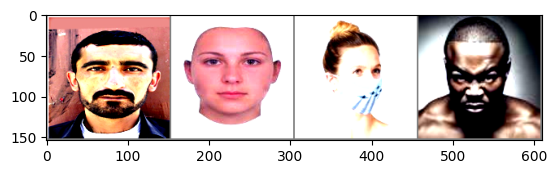

no_mask no_mask mask  no_mask


In [5]:
classes = ('mask','no_mask')

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [6]:
labels

tensor([1, 1, 0, 1])

In [7]:
net = Network()
print(net)

Network(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=20736, out_features=128, bias=True)
  (relu4): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Li

In [8]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001, momentum=0.9)

In [20]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:    # print every 200 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 200:.3f}')
            running_loss = 0.0

print('Finished Training')

/home/pratik/Documents/dev_v_super/Project1/myvenv/lib/python3.10/site-packages/torch/autograd/__init__.py:197: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


[1,   200] loss: 0.561
[1,   400] loss: 0.479
[1,   600] loss: 0.421


/home/pratik/Documents/dev_v_super/Project1/myvenv/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[1,   800] loss: 0.367
[1,  1000] loss: 0.401
[1,  1200] loss: 0.383
[1,  1400] loss: 0.411
[1,  1600] loss: 0.392
[2,   200] loss: 0.335
[2,   400] loss: 0.355
[2,   600] loss: 0.369
[2,   800] loss: 0.386
[2,  1000] loss: 0.322
